## Introduction

This investigation is to look at historic maximum temperatures in Cheltenham, VIC to see if there is any evidence for climate change.


## Source

Data is sourced from the [BOM](http://www.bom.gov.au/vic/forecasts/melbourne.shtml) for Cheltenham, Victoria. 

In [317]:
%matplotlib inline
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.dates as dates
import matplotlib.pyplot as plt

## Load CSV Data

In [226]:
data = pd.read_csv(
    'data/IDCJAC0010_086077_1800_Data.csv',
    usecols=['Year', 'Month', 'Day', 'Maximum temperature (Degree C)'])
data[data.Year == 1980].head()

,Year,Month,Day,Maximum temperature (Degree C)
3287,1980,1,1,19.6
3288,1980,1,2,31.4
3289,1980,1,3,33.6
3290,1980,1,4,20.4
3291,1980,1,5,19.3


Extract the Year, Month and Day columns into a date column.

In [227]:
df = pd.DataFrame(data=pd.to_datetime(data[['Year', 'Month', 'Day']]),
                  columns=['date'])
df, df.dtypes, df.columns

(            date
 0     1971-01-01
 1     1971-01-02
 2     1971-01-03
 3     1971-01-04
 4     1971-01-05
 ...          ...
 18543 2021-10-08
 18544 2021-10-09
 18545 2021-10-10
 18546 2021-10-11
 18547 2021-10-12
 
 [18548 rows x 1 columns],
 date    datetime64[ns]
 dtype: object,
 Index(['date'], dtype='object'))

In [228]:
df['months'] = df['date'].dt.strftime('%Y-%m')        # required for analysis
# df['period'] = df['date'].map(dt.datetime.toordinal)  # required for linear regression
df, df.dtypes, df.columns

(            date   months
 0     1971-01-01  1971-01
 1     1971-01-02  1971-01
 2     1971-01-03  1971-01
 3     1971-01-04  1971-01
 4     1971-01-05  1971-01
 ...          ...      ...
 18543 2021-10-08  2021-10
 18544 2021-10-09  2021-10
 18545 2021-10-10  2021-10
 18546 2021-10-11  2021-10
 18547 2021-10-12  2021-10
 
 [18548 rows x 2 columns],
 date      datetime64[ns]
 months            object
 dtype: object,
 Index(['date', 'months'], dtype='object'))

Append temperatures:

In [229]:
df['maximum'] = data['Maximum temperature (Degree C)']
df, df.dtypes, df.columns

(            date   months  maximum
 0     1971-01-01  1971-01      NaN
 1     1971-01-02  1971-01      NaN
 2     1971-01-03  1971-01      NaN
 3     1971-01-04  1971-01      NaN
 4     1971-01-05  1971-01      NaN
 ...          ...      ...      ...
 18543 2021-10-08  2021-10     21.2
 18544 2021-10-09  2021-10     25.0
 18545 2021-10-10  2021-10     15.4
 18546 2021-10-11  2021-10     14.5
 18547 2021-10-12  2021-10     19.5
 
 [18548 rows x 3 columns],
 date       datetime64[ns]
 months             object
 maximum           float64
 dtype: object,
 Index(['date', 'months', 'maximum'], dtype='object'))

Drop missing data:

In [230]:
df.dropna(subset=['maximum'], inplace=True)

Group by year and month (`period`):

In [231]:
# ym = group by year & month
ym = df.groupby(['months'])['maximum'].mean().reset_index()
ym

,months,maximum
0,1971-08,14.139286
1,1971-09,16.240000
2,1971-10,18.238710
3,1971-11,19.500000
4,1971-12,24.074194
...,...,...
596,2021-06,15.163333
597,2021-07,14.306667
598,2021-08,16.225000
599,2021-09,18.044828


What are the hottest months?

In [232]:
ym[ym.maximum > 29.0].sort_values('maximum')

,months,maximum
567,2019-01,29.045161
304,1997-02,29.142308
138,1983-02,29.239286
340,2000-02,29.418519
113,1981-01,29.487097


So, lets reduce our data frame to just the average of January and Feburary for each year.

In [233]:
# hm = hottest months
hm = df[df['date'].dt.month.between(1, 2)].groupby(['months'])['maximum'].mean().reset_index()
hm

,months,maximum
0,1972-01,24.764516
1,1972-02,26.906897
2,1973-01,27.154839
3,1973-02,25.628571
4,1974-01,28.209677
...,...,...
95,2019-02,26.532143
96,2020-01,26.932258
97,2020-02,24.306897
98,2021-01,25.383871


Can't predict on `str` or `datetime`, so use the ordinal, `period`:

In [249]:
# dfp = data frame for prediction
hm['period'] = pd.to_datetime(hm.months).map(dt.datetime.toordinal)
hm

,months,maximum,period
0,1972-01,24.764516,719893
1,1972-02,26.906897,719924
2,1973-01,27.154839,720259
3,1973-02,25.628571,720290
4,1974-01,28.209677,720624
...,...,...,...
95,2019-02,26.532143,737091
96,2020-01,26.932258,737425
97,2020-02,24.306897,737456
98,2021-01,25.383871,737791


Determine a least squares regression line:

In [250]:
# least squares polynomial fit (returns polynomial coefficients)
pc = np.polyfit(x=hm['period'], y=hm['maximum'], deg=1)
pc

array([ 4.56113712e-05, -7.26549542e+00])

In [251]:
# convert to pandas 1-dimensional polynomial so we can fit to dataframe
f = np.poly1d(pc)
f

poly1d([ 4.56113712e-05, -7.26549542e+00])

In [329]:
ord_to_str_fmt = lambda x: x.map(dt.datetime.fromordinal)
# .dt.strftime('%Y-%m')
# hm.period.map(dt.datetime.fromordinal).dt.strftime('%Y-%m')
# periods = hm.months.map(str)    # x axis labels as string dates
nums = dates.date2num(hm.months)
nums , dates.num2date(nums)


(array([  730.,   761.,  1096.,  1127.,  1461.,  1492.,  1826.,  1857.,
         2191.,  2222.,  2557.,  2588.,  2922.,  2953.,  3287.,  3318.,
         3652.,  3683.,  4018.,  4049.,  4383.,  4414.,  4748.,  4779.,
         5113.,  5144.,  5479.,  5510.,  5844.,  5875.,  6209.,  6240.,
         6574.,  6605.,  6940.,  6971.,  7305.,  7336.,  7670.,  7701.,
         8035.,  8066.,  8401.,  8432.,  8766.,  8797.,  9131.,  9162.,
         9496.,  9527.,  9862.,  9893., 10227., 10258., 10592., 10623.,
        10957., 10988., 11323., 11354., 11688., 11719., 12053., 12084.,
        12418., 12449., 12784., 12815., 13149., 13180., 13514., 13545.,
        13879., 13910., 14245., 14276., 14610., 14641., 14975., 15006.,
        15340., 15371., 15706., 15737., 16071., 16102., 16436., 16467.,
        16801., 16832., 17167., 17198., 17532., 17563., 17897., 17928.,
        18262., 18293., 18628., 18659.]),
 [datetime.datetime(1972, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
  datetime.datetime(1972,

Plot with regression

AttributeError: module 'matplotlib.pyplot' has no attribute 'dates'

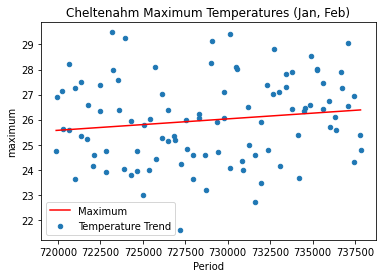

In [312]:
ax = plt.gca() # get current axes
hm.plot(kind='scatter', x='period', y='maximum', label='Maximum', ax=ax)
hm.plot('period', 'prediction', color='red', label='Temperature Trend', ax=ax)
plt.title('Cheltenahm Maximum Temperatures (Jan, Feb)')
plt.xlabel('Period')
ax.xaxis.set_major_formatter(plt.dates.DateFormatter('%Y-%m'))
plt.ylabel('Maximum Temperature °C')
plt.legend()
plt.show()